In [1]:
import numpy as np
import os, sys
sys.path.append('environments/')
import numpy as np
import pandas as pd
import random
import pickle, os, csv, math, time, joblib
from joblib import Parallel, delayed
import datetime as dt
from datetime import date, datetime, timedelta
from collections import Counter
import copy as cp
import tqdm
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import log_loss, f1_score, precision_score, recall_score, accuracy_score
#import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker
import collections 
#import shap
import seaborn as sns
import random
from sklearn.linear_model import LinearRegression
np.seterr(all="ignore")
import matplotlib.pyplot as plt
import tqdm
import math
import statsmodels.api as sm
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import json
import util as util_fqi
import sys
sys.path.append('models/')
from lmmfqi import LMMFQIagent
from fqi import FQIagent
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from os.path import join as pjoin
from sepsis_env import SepsisEnv

# Generate Tuples

In [2]:
env = SepsisEnv()
fg_tuples = env.generate_tuples(group="foreground", n_trajectories=10)
bg_tuples = env.generate_tuples(group="background", n_trajectories=10)

/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

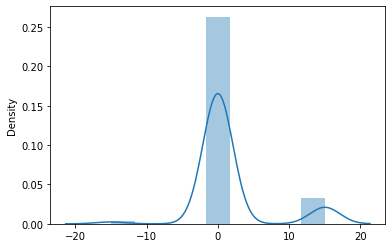

In [3]:
rewards = [x[3] for x in fg_tuples]
sns.distplot(rewards)

In [4]:
all_tuples = bg_tuples + fg_tuples
random.shuffle(all_tuples)
split = 0.8
train_tuples = all_tuples[:int(split*len(all_tuples))]
test_tuples = all_tuples[int(split*len(all_tuples)):]

In [5]:
len(train_tuples)

132

# Train Agents

N actions:  25
Learning policy
Run 0 :
Initialize: get batch, set initial Q
Learn policy
Opta:  [ 0  0  0  0  7  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0
  0 20  0  0  0 20 20 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 20  0  0  0  0  0 20  0 20  0  0  0  0  0  0  0 20  0  0  7  0  0  0  0
  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  7  0  0  0 20  0 20  0 20  0  0  0  0  0  0  0  0 20  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0]


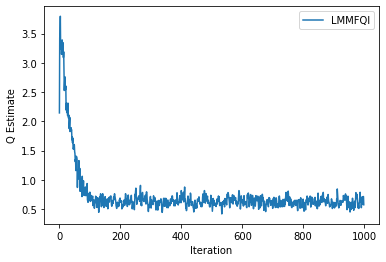

In [7]:
lmm_agent = LMMFQIagent(train_tuples=train_tuples, test_tuples=test_tuples, estimator='gbm', gamma=0.99, state_dim=46, batch_size=len(train_tuples), iters=1000)
# The two policies are in lmm_agent.piE_foreground and lmm_agent.piE_background
Q_dist = lmm_agent.runFQI(repeats=1)
plt.plot(Q_dist, label= "LMMFQI")
plt.xlabel("Iteration")
plt.ylabel("Q Estimate")
plt.legend()
plt.show()

In [ ]:
fqi_agent = FQIagent(train_tuples=train_tuples, test_tuples=test_tuples, state_dim=46, gamma=0.5, batch_size=36, iters=200, estimator='gbm')
Q_dist = fqi_agent.runFQI(repeats=10)
plt.plot(Q_dist, label= "FQI")
plt.xlabel("Iteration")
plt.ylabel("Q Estimate")
plt.legend()
plt.show()